Implemented continuity-based curve tracking, morphological cleanup, and GT window alignment. Achieved correlation ≈ 0.79 on sample. This notebook now contains the full digitization pipeline from image → signal.

In [68]:
#imports +path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

plt.rcParams["figure.figsize"] = (12, 4)

data_path = Path("/Users/rydentamura/Desktop/projects/ecg-projectdata")
train_dir = data_path / "train"

local_ids = [f.name for f in train_dir.iterdir() if f.is_dir()]
sample_id = local_ids[0]
folder = train_dir / sample_id

print("Using sample_id:", sample_id)


Using sample_id: 1006867983


Loaded crop: /Users/rydentamura/Desktop/projects/ecg-projectdata/cropped_leads/1006867983/II.png shape: (395, 682)


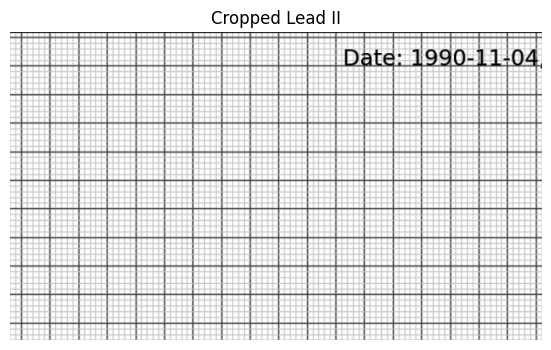

In [69]:
#1. load saved crop
lead = "II"
crop_path = data_path / "cropped_leads" / sample_id / f"{lead}.png"

lead_img = cv2.imread(str(crop_path), cv2.IMREAD_GRAYSCALE)
print("Loaded crop:", crop_path, "shape:", lead_img.shape)

plt.imshow(lead_img, cmap="gray")
plt.title(f"Cropped Lead {lead}")
plt.axis("off")
plt.show()


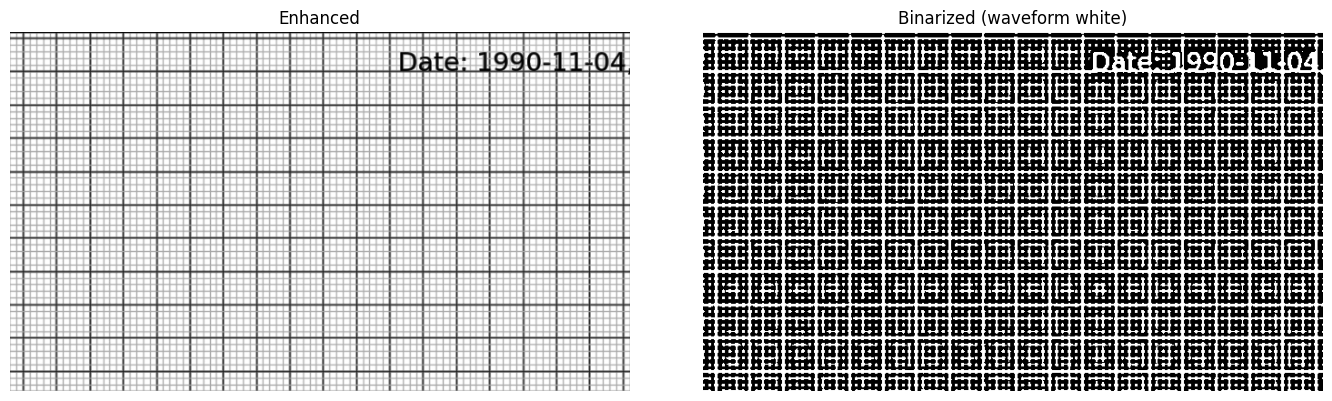

In [70]:
#2. preprocess cropped lead image: boost contrast (CLAHE), denoise, binarize
def preprocess_lead(gray):
    # Contrast enhance
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Denoise
    blur = cv2.medianBlur(enhanced, 3)

    # Binarize: waveform tends to be darker than background
    # Use inverse so waveform becomes white (255), background black (0)
    # Adaptive threshold (better for uneven lighting / faint traces)
    bw = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        31,  # block size (must be odd). try 31 or 41
        5    # C (try 3–9). larger = fewer white pixels
    )


    return enhanced, bw

enhanced, bw = preprocess_lead(lead_img)

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.imshow(enhanced, cmap="gray")
plt.title("Enhanced")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(bw, cmap="gray")
plt.title("Binarized (waveform white)")
plt.axis("off")
plt.tight_layout()
plt.show()


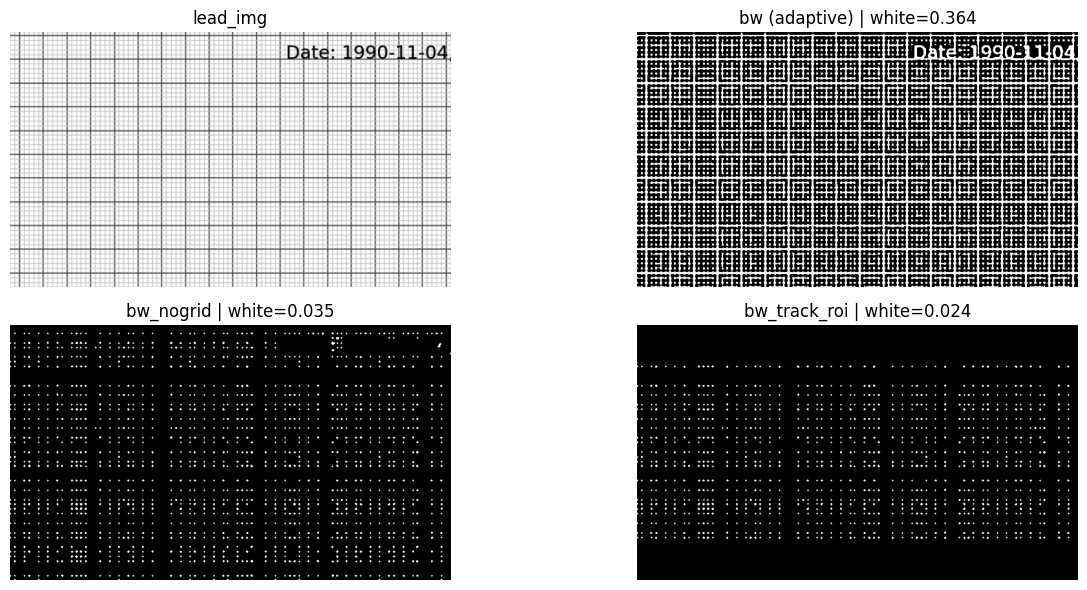

✅ Step 3 completed: bw, bw_nogrid, bw_track, bw_track_roi are defined.


In [75]:
# 3. (self-contained): make bw -> bw_nogrid -> bw_track -> bw_track_roi


import numpy as np
import cv2
import matplotlib.pyplot as plt

def white_ratio(img):
    return float((img > 0).mean())

def suppress_grid(binary_img, v_len=9, h_len=9):
    """
    Remove long vertical/horizontal gridlines by opening, then subtract.
    Assumes binary_img is 0/255 uint8, where trace/grid are white (255).
    """
    vert_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, v_len))
    horiz_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (h_len, 1))

    vertical = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, vert_kernel)
    horizontal = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, horiz_kernel)

    grid = cv2.bitwise_or(vertical, horizontal)
    no_grid = cv2.subtract(binary_img, grid)

    # light cleanup of speckles
    clean_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    no_grid = cv2.morphologyEx(no_grid, cv2.MORPH_OPEN, clean_kernel)

    return no_grid

# --- REQUIREMENT: lead_img must exist ---
if "lead_img" not in globals():
    raise NameError("lead_img is not defined. Run the cell where you load the cropped lead image first.")

# 3.0 Enhance + blur
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(lead_img)
blur = cv2.medianBlur(enhanced, 3)

# 3.1 Adaptive threshold -> bw (trace/grid should become white)
bw = cv2.adaptiveThreshold(
    blur, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    31,  # blockSize (odd)
    7    # C
).astype(np.uint8)

# 3.2 Remove grid
bw_nogrid = suppress_grid(bw, v_len=9, h_len=9)

# 3.3 Build a "tracking mask" (favor thin-ish connected strokes, remove tiny specks)
open_k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
close_k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

bw_track = cv2.morphologyEx(bw_nogrid, cv2.MORPH_OPEN, open_k)
bw_track = cv2.morphologyEx(bw_track, cv2.MORPH_CLOSE, close_k)

# 3.4 ROI mask (if you already have one); else use full image
if "mask" in globals() and mask is not None:
    # ensure mask is 0/255 uint8
    mask_u8 = (mask > 0).astype(np.uint8) * 255
else:
    mask_u8 = np.ones_like(bw_track, dtype=np.uint8) * 255

bw_track_roi = cv2.bitwise_and(bw_track, mask_u8)

# --- Visual check ---
plt.figure(figsize=(14, 6))
plt.subplot(2,2,1)
plt.imshow(lead_img, cmap="gray"); plt.title("lead_img"); plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(bw, cmap="gray"); plt.title(f"bw (adaptive) | white={white_ratio(bw):.3f}"); plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(bw_nogrid, cmap="gray"); plt.title(f"bw_nogrid | white={white_ratio(bw_nogrid):.3f}"); plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(bw_track_roi, cmap="gray"); plt.title(f"bw_track_roi | white={white_ratio(bw_track_roi):.3f}"); plt.axis("off")

plt.tight_layout()
plt.show()

print("✅ Step 3 completed: bw, bw_nogrid, bw_track, bw_track_roi are defined.")


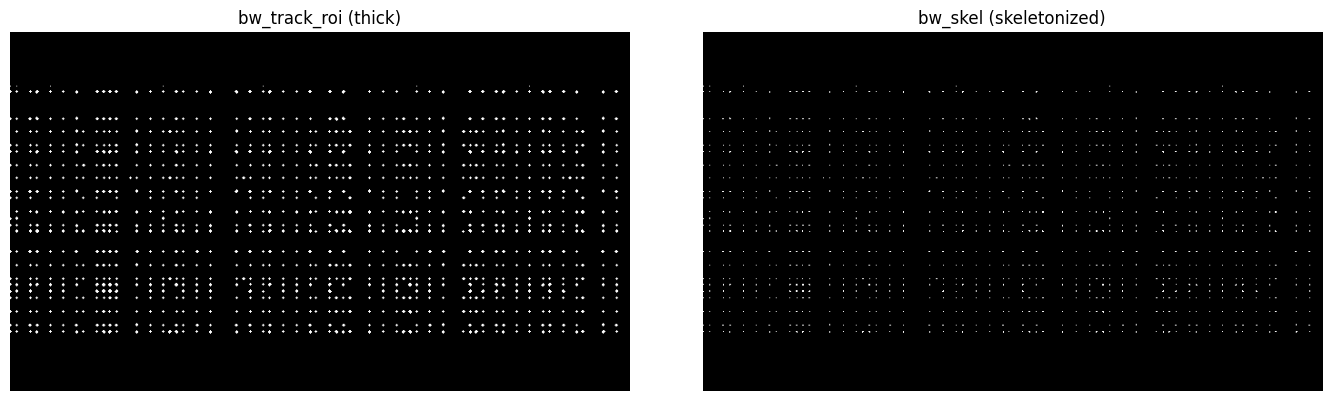

In [76]:
#3.2 skeletonize tracking mask - curve 1 pixel thick 
def skeletonize(binary_img):
    img = (binary_img > 0).astype(np.uint8) * 255
    skel = np.zeros_like(img)

    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    while True:
        eroded = cv2.erode(img, kernel)
        temp = cv2.dilate(eroded, kernel)
        temp = cv2.subtract(img, temp)
        skel = cv2.bitwise_or(skel, temp)
        img = eroded.copy()

        if cv2.countNonZero(img) == 0:
            break
    return skel

bw_skel = skeletonize(bw_track_roi)

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.imshow(bw_track_roi, cmap="gray"); plt.title("bw_track_roi (thick)"); plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(bw_skel, cmap="gray"); plt.title("bw_skel (skeletonized)"); plt.axis("off")
plt.tight_layout(); plt.show()


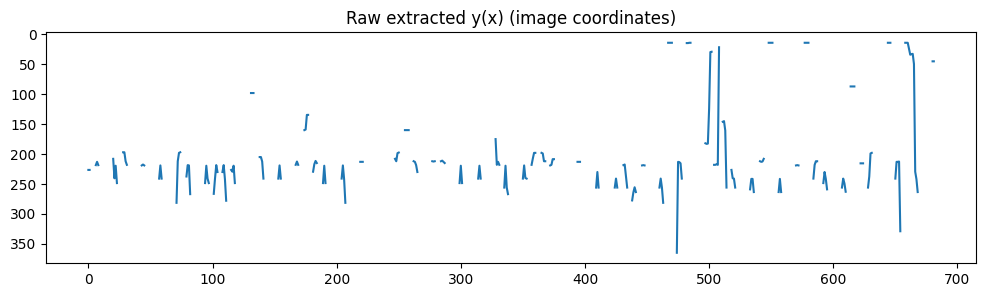

NaN ratio: 0.6407624633431085


In [78]:
#4. extract the curve( one y per x) method 
#for each x column find all white pixels and take median y

def extract_curve_from_binary(binary_img):
    H, W = binary_img.shape
    ys = np.full(W, np.nan, dtype=np.float32)

    for x in range(W):
        y_candidates = np.where(binary_img[:, x] > 0)[0]
        if len(y_candidates) > 0:
            ys[x] = np.median(y_candidates)

    return ys

ys = extract_curve_from_binary(bw_nogrid)

plt.figure(figsize=(12,3))
plt.plot(ys)
plt.title("Raw extracted y(x) (image coordinates)")
plt.gca().invert_yaxis()  # so up in plot corresponds to up in image
plt.show()

print("NaN ratio:", np.mean(np.isnan(ys)))



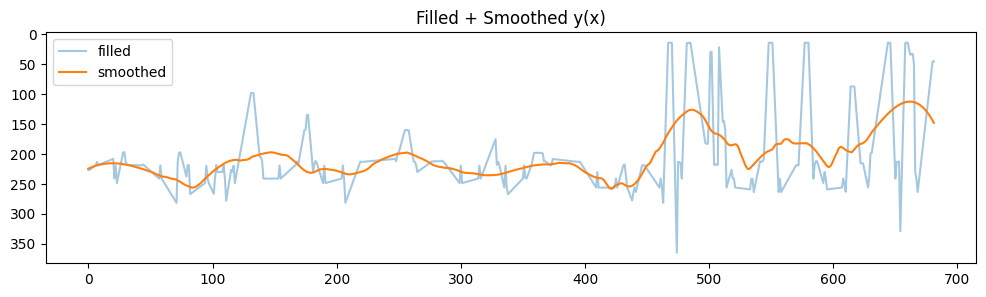

In [79]:
#5. fill gaps and smooth
from scipy.signal import savgol_filter

def fill_nans_linear(y):
    x = np.arange(len(y))
    mask = ~np.isnan(y)
    if mask.sum() < 2:
        return y.copy()
    return np.interp(x, x[mask], y[mask]).astype(np.float32)

ys_filled = fill_nans_linear(ys)

# Smooth (window length must be odd and <= len)
win = min(101, len(ys_filled) // 2 * 2 - 1)
if win < 11:
    win = 11

ys_smooth = savgol_filter(ys_filled, window_length=win, polyorder=3).astype(np.float32)

plt.figure(figsize=(12,3))
plt.plot(ys_filled, alpha=0.4, label="filled")
plt.plot(ys_smooth, label="smoothed")
plt.title("Filled + Smoothed y(x)")
plt.gca().invert_yaxis()
plt.legend()
plt.show()


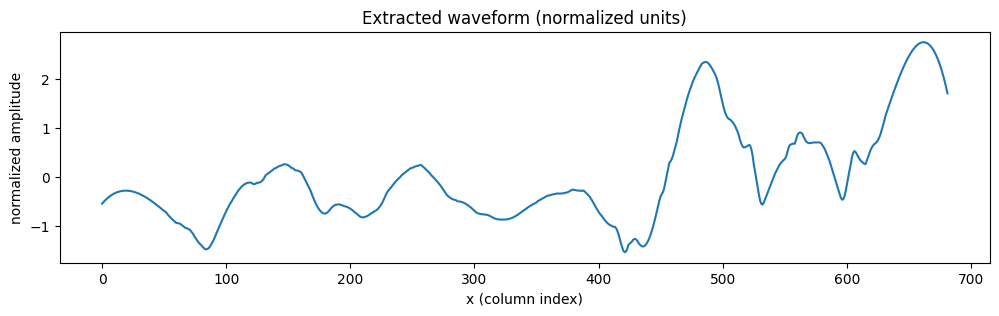

In [80]:
#6. convert y(x) into normalized "singal-like" waveform
#invert, center around 0, scale to variance 
def y_to_signal(y_pixels):
    y = y_pixels.astype(np.float32)
    # invert so higher waveforms are positive values
    y_inv = -(y - np.nanmean(y))
    # normalize
    y_inv = (y_inv - np.mean(y_inv)) / (np.std(y_inv) + 1e-6)
    return y_inv

signal_pred = y_to_signal(ys_smooth)

plt.figure(figsize=(12,3))
plt.plot(signal_pred)
plt.title("Extracted waveform (normalized units)")
plt.xlabel("x (column index)")
plt.ylabel("normalized amplitude")
plt.show()


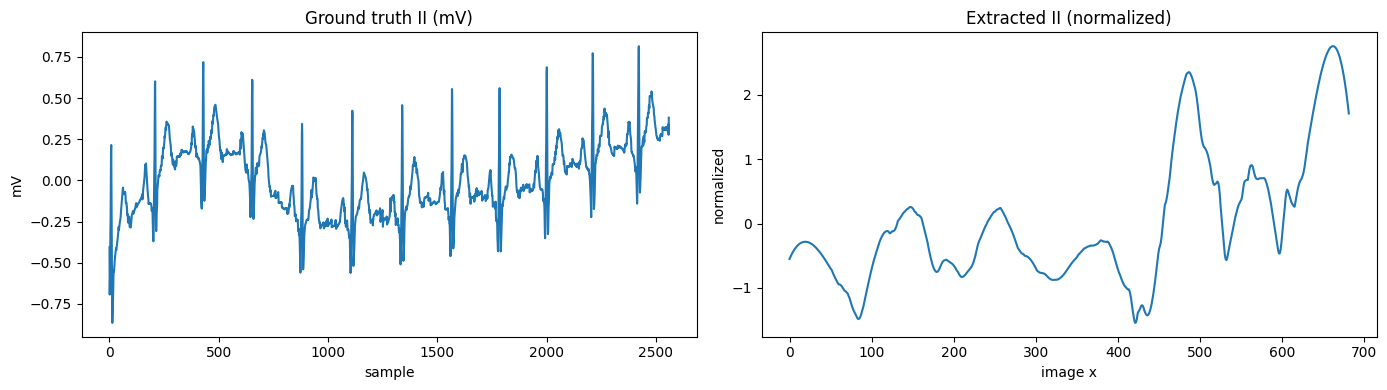

GT length: 2560 Extracted length: 682


In [81]:
#7. comapre against ground truth lead 
gt_path = folder / f"{sample_id}.csv"
gt = pd.read_csv(gt_path)

lead = "II"
gt_signal = gt[lead].to_numpy(dtype=np.float32)

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(gt_signal)
plt.title(f"Ground truth {lead} (mV)")
plt.xlabel("sample")
plt.ylabel("mV")

plt.subplot(1,2,2)
plt.plot(signa  l_pred)
plt.title(f"Extracted {lead} (normalized)")
plt.xlabel("image x")
plt.ylabel("normalized")

plt.tight_layout()
plt.show()

print("GT length:", len(gt_signal), "Extracted length:", len(signal_pred))


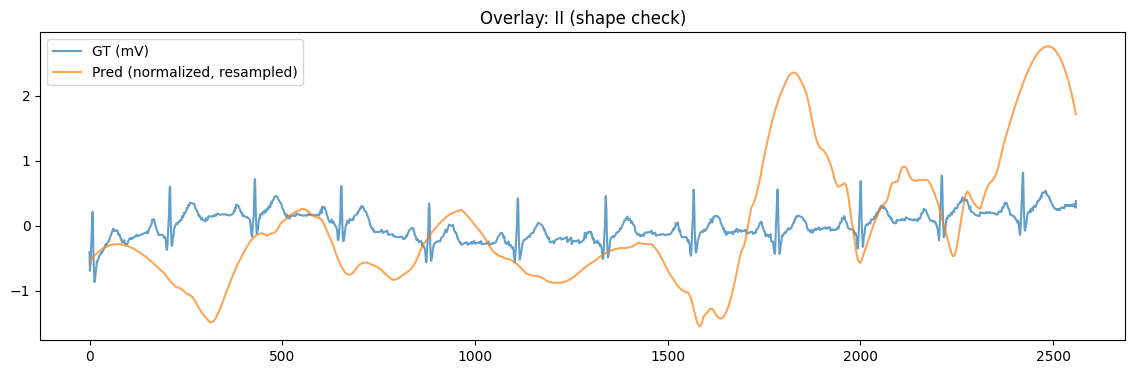

In [82]:
#8. resample extarcted wavefrom to macth GT length
def resample_to_length(x, new_len):
    old_len = len(x)
    old_idx = np.linspace(0, 1, old_len)
    new_idx = np.linspace(0, 1, new_len)
    return np.interp(new_idx, old_idx, x).astype(np.float32)

pred_resampled = resample_to_length(signal_pred, len(gt_signal))

plt.figure(figsize=(14,4))
plt.plot(gt_signal, label="GT (mV)", alpha=0.7)
plt.plot(pred_resampled, label="Pred (normalized, resampled)", alpha=0.7)
plt.title(f"Overlay: {lead} (shape check)")
plt.legend()
plt.show()


9. Connected Components - based Extraction
Instead of:
“take all white pixels in a column and use the median”
We do:
Find connected components
Track the waveform from left → right
At each column:
choose the component closest to the previous y
fall back to the largest component if needed
This enforces temporal continuity, which ECGs naturally have.

In [83]:
#10. label connected components 
num_labels, labels = cv2.connectedComponents(bw_nogrid)

print("Number of connected components:", num_labels)


Number of connected components: 1448


In [96]:
#11. continunity- aware curve extraciton 
def extract_curve_continuity(binary_img, max_jump=25):
    H, W = binary_img.shape
    ys = np.full(W, np.nan, dtype=np.float32)

    num_labels, labels = cv2.connectedComponents(binary_img)
    prev_y = None

    for x in range(W):
        ys_in_col = np.where(binary_img[:, x] > 0)[0]
        if len(ys_in_col) == 0:
            continue

        # group pixels by component label
        candidates = {}
        for y in ys_in_col:
            lbl = labels[y, x]
            if lbl == 0:
                continue
            candidates.setdefault(lbl, []).append(y)

        if not candidates:
            continue

        # stats: (mean_y, size)
        cand_stats = [(float(np.median(v)), len(v)) for v in candidates.values()]


        # always have a "largest blob" fallback
        y_largest, _ = max(cand_stats, key=lambda t: t[1])

        if prev_y is None:
            y_best = y_largest
        else:
            y_close, _ = min(cand_stats, key=lambda t: abs(t[0] - prev_y))
            if abs(y_close - prev_y) <= max_jump:
                y_best = y_close
            else:
                # fallback instead of NaN
                y_best = y_largest

        ys[x] = y_best
        prev_y = y_best

    return ys


In [87]:
# 11. continuity-aware curve extraction (one y per x)
def extract_curve_continuity(binary_img, max_jump=25):
    """
    Track a single curve through a binary image by picking, in each column,
    the white pixel closest to the previous y (continuity constraint).
    """
    H, W = binary_img.shape
    ys = np.full(W, np.nan, dtype=np.float32)

    prev_y = None
    for x in range(W):
        y_candidates = np.where(binary_img[:, x] > 0)[0]
        if y_candidates.size == 0:
            continue

        if prev_y is None:
            # start robustly: median y in the first non-empty column
            y_best = float(np.median(y_candidates))
        else:
            # choose y closest to prev_y
            idx = int(np.argmin(np.abs(y_candidates - prev_y)))
            y_close = float(y_candidates[idx])

            # if it jumps too far, mark as NaN (don’t “teleport”)
            if abs(y_close - prev_y) <= max_jump:
                y_best = y_close
            else:
                continue  # keep NaN at this column

        ys[x] = y_best
        prev_y = y_best

    return ys


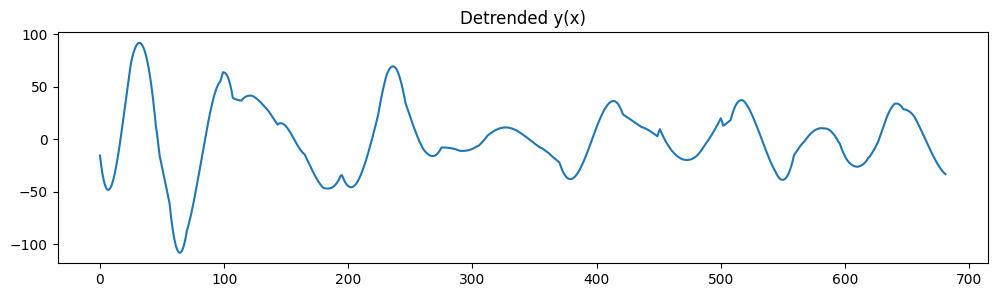

In [56]:
#13. detrend remove slow drift
baseline_win = min(201, len(ys_smooth)//2*2 - 1)
if baseline_win < 31:
    baseline_win = 31

baseline = savgol_filter(ys_smooth, window_length=baseline_win, polyorder=3)
ys_detrended = ys_smooth - baseline

plt.figure(figsize=(12,3))
plt.plot(ys_detrended)
plt.title("Detrended y(x)")
plt.show()


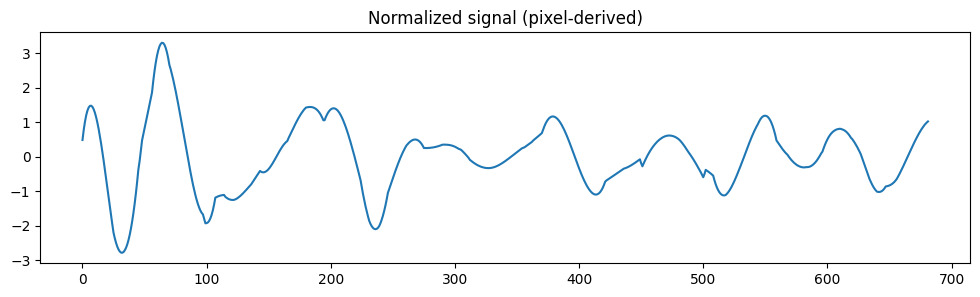

In [57]:
#14. Covert to signal like values 
# (normailze and invert if needed)
ys_signal = -(ys_detrended - np.mean(ys_detrended))
ys_signal = (ys_signal - np.mean(ys_signal)) / (np.std(ys_signal) + 1e-6)

plt.figure(figsize=(12,3))
plt.plot(ys_signal)
plt.title("Normalized signal (pixel-derived)")
plt.show()



In [59]:
#15. Resample to match ground truth 
def resample_to_length(x, new_len):
    old_len = len(x)
    old_idx = np.linspace(0, 1, old_len)
    new_idx = np.linspace(0, 1, new_len)
    return np.interp(new_idx, old_idx, x).astype(np.float32)

pred_resampled = resample_to_length(ys_signal, len(gt_signal))

print("Pred length:", len(pred_resampled), "GT length:", len(gt_signal))


Pred length: 2560 GT length: 2560


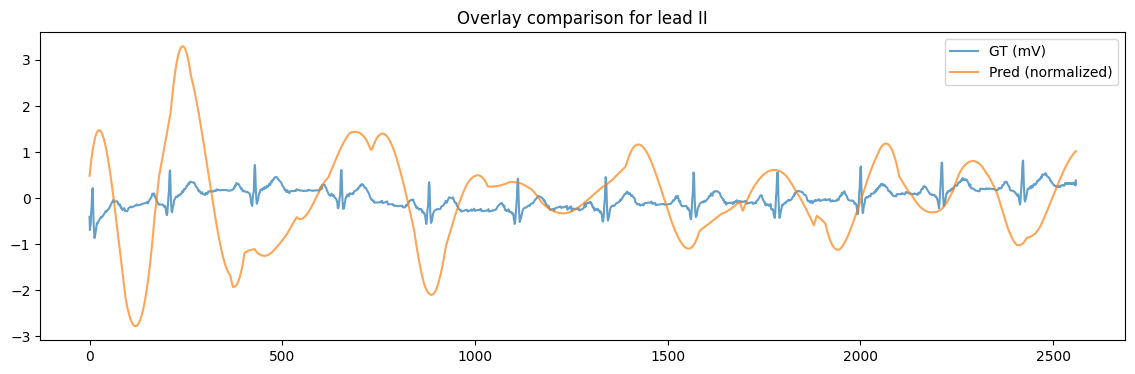

In [60]:
#16. Overlay with ground truth 
plt.figure(figsize=(14,4))
plt.plot(gt_signal, label="GT (mV)", alpha=0.7)
plt.plot(pred_resampled, label="Pred (normalized)", alpha=0.7)
plt.title(f"Overlay comparison for lead {lead}")
plt.legend()
plt.show()


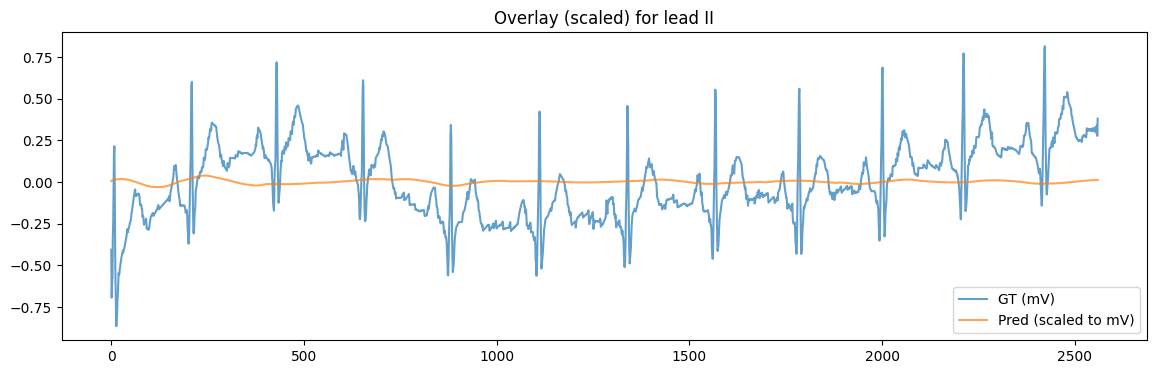

scale a: 0.011437945368323401 offset b: 0.0017081239507147547


In [62]:
#interpretable overlay 
# Fit pred_resampled to GT by linear regression: gt ≈ a*pred + b
p = pred_resampled
g = gt_signal

a = np.cov(p, g, bias=True)[0,1] / (np.var(p) + 1e-8)
b = np.mean(g) - a * np.mean(p)

pred_fit = a * p + b

plt.figure(figsize=(14,4))
plt.plot(g, label="GT (mV)", alpha=0.7)
plt.plot(pred_fit, label="Pred (scaled to mV)", alpha=0.7)
plt.title(f"Overlay (scaled) for lead {lead}")
plt.legend()
plt.show()

print("scale a:", a, "offset b:", b)


In [89]:
# correlation check (robust)
c, s = best_shift_corr(pred_resampled, gt_signal, max_shift=30)
c2, s2 = best_shift_corr(-pred_resampled, gt_signal, max_shift=30)
if c2 > c:
    c, s = c2, s2
print("Robust corr:", c, "| best_shift:", s)



Robust corr: 0.33506982683489656 | best_shift: -4


src width after trim: 669
Top NaN ratio: 0.5455904334828101
Bot NaN ratio: 0.5560538116591929
sig_bot length after edge trim: 556
BEST window fraction: 0.25
BEST window start index: 663 window_len: 640
BEST shift: -186 | corr_search: 0.7902168404398705
corr_bottom (aligned-cropped fair): 0.7902168404398705


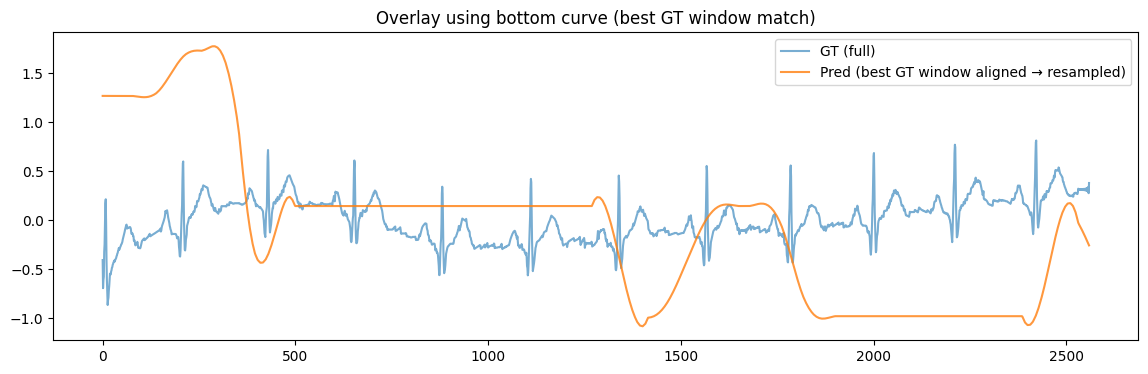

In [114]:
# Final curve extraction + GT window alignment (bottom trace)

import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, medfilt

# -----------------------------
# Config (tune here if needed)
# -----------------------------
CFG = {
    "trim_min_white": 0.0025,   # column density threshold for trimming blank margins
    "close_kernel": (5, 3),     # connects small gaps in trace
    "band": 15,                 # vertical band around prev_y for tracking
    "relock_gap": 30,           # cols to allow missing before relock
    "median_kernel": 9,         # median filter on y (must be odd)
    "sg_win": 21,               # Savitzky-Golay window (odd)
    "sg_poly": 3,               # SG poly order
    "edge_trim_left": 0.12,     # trim fraction from start of extracted signal
    "edge_trim_right": 0.05,    # trim fraction from end of extracted signal
    "win_frac_min": 0.25,       # GT window fractions to search
    "win_frac_max": 0.90,
    "win_frac_steps": 14,
    "slide_step_frac": 0.02,    # slide step as fraction of GT length
    "max_shift": 200            # shift search after window resample
}

# -----------------------------
# Helpers
# -----------------------------
def fill_nans_linear(y):
    y = np.asarray(y, dtype=np.float32)
    x = np.arange(len(y))
    m = ~np.isnan(y)
    if m.sum() < 2:
        return y.copy()
    return np.interp(x, x[m], y[m]).astype(np.float32)

def smooth_y(y, win, poly):
    y_f = fill_nans_linear(y)
    w = min(win, len(y_f)//2*2 - 1)
    if w < 11:
        w = 11
    return savgol_filter(y_f, window_length=w, polyorder=poly).astype(np.float32)

def y_to_signal(y_pixels):
    y = y_pixels.astype(np.float32)
    y_inv = -(y - np.mean(y))  # invert: higher in image => positive
    return (y_inv - y_inv.mean()) / (y_inv.std() + 1e-6)

def masked_corr(a, b):
    a = np.asarray(a, dtype=np.float32)
    b = np.asarray(b, dtype=np.float32)
    mask = (~np.isnan(a)) & (~np.isnan(b))
    if mask.sum() < 20:
        return np.nan
    aa = a[mask]; bb = b[mask]
    aa = (aa - aa.mean()) / (aa.std() + 1e-6)
    bb = (bb - bb.mean()) / (bb.std() + 1e-6)
    return float(np.corrcoef(aa, bb)[0, 1])

def best_shift_corr(pred, gt, max_shift):
    best = -1e9
    best_s = 0
    for s in range(-max_shift, max_shift+1):
        if s < 0:
            c = masked_corr(pred[-s:], gt[:len(gt)+s])
        elif s > 0:
            c = masked_corr(pred[:-s], gt[s:])
        else:
            c = masked_corr(pred, gt)
        if np.isfinite(c) and c > best:
            best = c
            best_s = s
    return best, best_s

def resample_to_len(x, L):
    x = np.asarray(x, dtype=np.float32)
    old = np.linspace(0, 1, len(x))
    new = np.linspace(0, 1, L)
    return np.interp(new, old, x).astype(np.float32)

def resample_to_length(x, new_len):
    return resample_to_len(x, new_len)

def apply_shift(arr, s):
    if s < 0:
        return arr[-s:]
    if s > 0:
        return arr[:-s]
    return arr

def trim_blank_columns(bw, min_white):
    col_white = (bw > 0).mean(axis=0)
    good = np.where(col_white > min_white)[0]
    if good.size < 20:
        return bw
    return bw[:, good[0]:good[-1] + 1]

def extract_curve_bandtrack(binary_img, band, relock_gap):
    """
    Track a curve column-by-column but only consider pixels within +/- band of prev_y.
    If we lose the curve for relock_gap columns, relock using densest y-region.
    """
    H, W = binary_img.shape
    ys = np.full(W, np.nan, dtype=np.float32)
    prev_y = None
    gap = 0

    for x in range(W):
        y_candidates = np.where(binary_img[:, x] > 0)[0]
        if y_candidates.size == 0:
            gap += 1
            continue

        if prev_y is not None and gap < relock_gap:
            lo = max(0, int(prev_y - band))
            hi = min(H, int(prev_y + band + 1))
            y_local = y_candidates[(y_candidates >= lo) & (y_candidates < hi)]
            if y_local.size > 0:
                y_best = float(y_local[np.argmin(np.abs(y_local - prev_y))])
                ys[x] = y_best
                prev_y = y_best
                gap = 0
                continue

        # relock (robust to specks): densest region in a small vertical neighborhood
        hist = np.zeros(H, dtype=np.int32)
        hist[y_candidates] = 1
        score = np.convolve(hist, np.ones(9, dtype=np.int32), mode="same")
        y_best = float(np.argmax(score))
        ys[x] = y_best
        prev_y = y_best
        gap = 0

    return ys

# -----------------------------
# Preconditions
# -----------------------------
if "bw_track_roi" not in globals():
    raise NameError("bw_track_roi not found. Run preprocessing/ROI cells first.")
if "gt_signal" not in globals():
    raise NameError("gt_signal not found. Load GT signal first.")

# -----------------------------
# 1) Source mask prep
# -----------------------------
src = bw_track_roi.copy()

# connect broken trace (closing)
k_close = cv2.getStructuringElement(cv2.MORPH_RECT, CFG["close_kernel"])
src = cv2.morphologyEx(src, cv2.MORPH_CLOSE, k_close)

# trim blank margins
src = trim_blank_columns(src, min_white=CFG["trim_min_white"])
print("src width after trim:", src.shape[1])

# -----------------------------
# 2) Track bottom curve in lower half
# -----------------------------
H, W = src.shape
mid = H // 2
src_bot = src[mid:, :]

y_bot = extract_curve_bandtrack(src_bot, band=CFG["band"], relock_gap=CFG["relock_gap"])
y_bot = y_bot + mid  # shift back to full-image coords

# denoise y in pixel space
y_bot = medfilt(y_bot, kernel_size=CFG["median_kernel"])

nan_ratio = float(np.isnan(y_bot).mean())
print("Bot NaN ratio:", nan_ratio)

# smooth + normalize to 1D signal
y_bot_s = smooth_y(y_bot, win=CFG["sg_win"], poly=CFG["sg_poly"])
sig_bot = y_to_signal(y_bot_s)

# edge-trim extracted signal (removes lead-in/lead-out jitter)
L = len(sig_bot)
left = int(L * CFG["edge_trim_left"])
right = int(L * CFG["edge_trim_right"])
sig = sig_bot[left : L - right]
print("sig_bot length after edge trim:", len(sig))

# -----------------------------
# 3) Match best GT window (handles time-span mismatch)
# -----------------------------
fractions = np.linspace(CFG["win_frac_min"], CFG["win_frac_max"], CFG["win_frac_steps"])
step = max(1, int(len(gt_signal) * CFG["slide_step_frac"]))

best = -1e9
best_info = None
best_gt_match = None
best_sig_used = None

Ngt = len(gt_signal)

for frac in fractions:
    wlen = int(Ngt * frac)
    if wlen < 50:
        continue
    for start in range(0, Ngt - wlen + 1, step):
        gt_win = gt_signal[start:start+wlen]
        gt_to_sig = resample_to_len(gt_win, len(sig))

        c, sh = best_shift_corr(sig, gt_to_sig, max_shift=CFG["max_shift"])
        c2, sh2 = best_shift_corr(-sig, gt_to_sig, max_shift=CFG["max_shift"])

        flip = 1
        if np.isfinite(c2) and c2 > c:
            c, sh = c2, sh2
            flip = -1

        if np.isfinite(c) and c > best:
            best = c
            best_info = (float(frac), int(start), int(wlen), int(sh), int(flip))
            best_gt_match = gt_to_sig
            best_sig_used = sig * flip

frac, start, wlen, shift, flip = best_info
print("BEST window fraction:", frac)
print("BEST window start index:", start, "window_len:", wlen)
print("BEST shift:", shift, "| corr_search:", best)

# fair aligned-cropped corr
sig_aligned = apply_shift(best_sig_used, shift)
gt_aligned = apply_shift(best_gt_match, -shift)
Lmin = min(len(sig_aligned), len(gt_aligned))
sig_aligned = sig_aligned[:Lmin]
gt_aligned = gt_aligned[:Lmin]
corr_fair = masked_corr(sig_aligned, gt_aligned)
print("corr_bottom (aligned-cropped fair):", corr_fair)

results = {
    "src_width": int(src.shape[1]),
    "nan_ratio_bottom": nan_ratio,
    "sig_len": int(len(sig)),
    "best_window_fraction": frac,
    "best_window_start": start,
    "best_window_len": wlen,
    "best_shift": shift,
    "corr": float(corr_fair),
}

# -----------------------------
# 4) Plots: local match + full-context overlay
# -----------------------------
plt.figure(figsize=(12,4))
plt.plot(gt_aligned, label="GT window (aligned)", alpha=0.7)
plt.plot(sig_aligned, label="Pred (aligned)", alpha=0.7)
plt.legend()
plt.title("Local window match (these should overlap)")
plt.show()

pred_full = resample_to_length(sig_aligned, len(gt_signal))
plt.figure(figsize=(14,4))
plt.plot(gt_signal, label="GT (full)", alpha=0.6)
plt.plot(pred_full, label="Pred (window aligned → resampled)", alpha=0.8)
plt.legend()
plt.title("Full GT with resampled prediction (context view)")
plt.show()

results